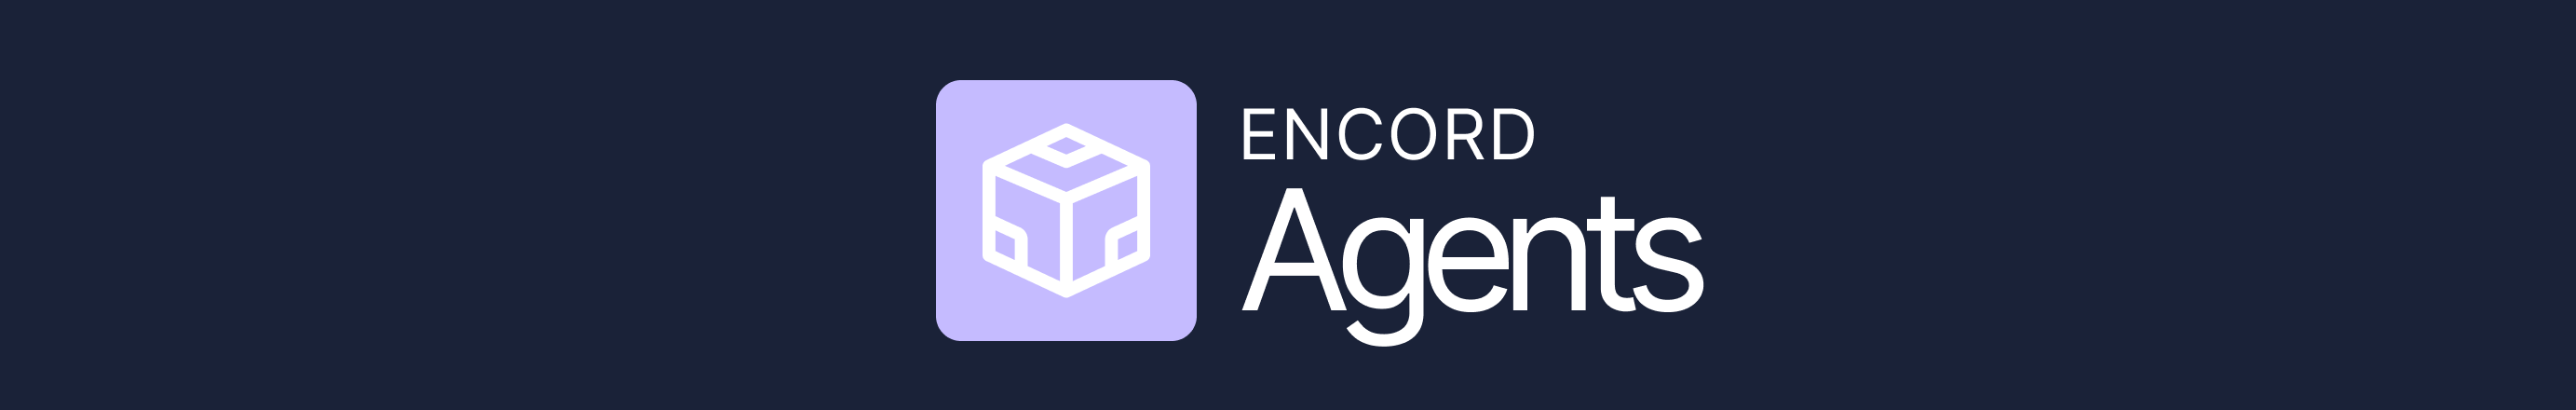

## LLM as a Judge

In the following example, we are combining multi-modal use cases and Editor layouts. The example involves taking LLM generated descriptions of an image and using a VLM to determine which is the best description of the image

In [ ]:
!pip install encord-agents openai

In [ ]:
from encord import EncordUserClient

In [ ]:
user_client = EncordUserClient.create_with_ssh_private_key()

In this scenario, in order to ensure that we perform the summarisation at most once for a given Editor Group, we need to build a mechanism of looking up the other items in the Group.


For this example, the schema is:
```python
'Tag': UUID,
'Data Type': ENUM: 'Image', 'Text_8B', 'Text_16B'
```

In [ ]:
PROJECT_HASH = "72ea688f-5266-494b-af79-2e005615456a"

In [ ]:
project = user_client.get_project(PROJECT_HASH)

In [ ]:
project

In [ ]:
lrs = project.list_label_rows_v2(include_client_metadata=True)

In [ ]:
tags: set[str] = {row.client_metadata["Tag"] for row in lrs}

In [ ]:
dict_tag_layout_components: dict[str, dict[str, str]] = {}
for tag in tags:
    matching_lrs = [row for row in lrs if row.client_metadata["Tag"] == tag]
    tag_dict = {}
    for lr in matching_lrs:
        tag_dict[lr.client_metadata["Data Type"]] = lr.data_hash
    dict_tag_layout_components[tag] = tag_dict

In [ ]:
dict_tag_layout_components

In [ ]:
from openai import OpenAI

In [ ]:
openai_client = OpenAI()

In [ ]:
from encord.objects.ontology_labels_impl import LabelRowV2

from encord_agents.core.ontology import OntologyDataModel


def select_pair_label_rows(lr: LabelRowV2) -> tuple[LabelRowV2, LabelRowV2]:
    lr_tag = lr.client_metadata["Tag"]
    tag_dict = dict_tag_layout_components[lr_tag]
    data_hash_8B = tag_dict["Text_8B"]
    data_hash_16B = tag_dict["Text_16B"]
    lr_8B = project.list_label_rows_v2(data_hashes=[data_hash_8B], include_client_metadata=True)[0]
    lr_16B = project.list_label_rows_v2(data_hashes=[data_hash_16B], include_client_metadata=True)[0]
    lr_8B.initialise_labels(include_signed_url=True)
    lr_16B.initialise_labels(include_signed_url=True)
    return lr_8B, lr_16B

In [ ]:
from contextlib import contextmanager
from pathlib import Path
from typing import Generator

import cv2
import numpy as np
from encord.objects.classification import Classification
from encord.objects.classification_instance import ClassificationInstance
from encord.objects.ontology_labels_impl import LabelRowV2
from encord.project import Project
from pydantic import ValidationError

from encord_agents.core.data_model import LabelRowMetadataIncludeArgs
from encord_agents.core.vision import b64_encode_image
from encord_agents.tasks import Runner
from encord_agents.tasks.dependencies import dep_asset

runner = Runner(project_hash=PROJECT_HASH)


@contextmanager
def fetch_asset_lr(lr: LabelRowV2) -> Generator[Path, None, None]:
    with contextmanager(dep_asset)(lr) as asset:
        yield asset


def get_schema_object(project: Project) -> OntologyDataModel[Classification]:
    classifications = project.ontology_structure.classifications
    trimmed_classifications = classifications[-3:-1]
    # Exclude the Final Choice
    ont_data_model = OntologyDataModel(trimmed_classifications)
    return ont_data_model


def call_openai(
    base64_img_url: str, choice_1: str, choice_2: str, ont_data_model: OntologyDataModel[Classification]
) -> list[ClassificationInstance]:
    prompt = f"""Please choose from the following two descriptions of the image which best summarises the Image.
    {choice_1=}
    {choice_2=}
    Please follow the JSON Schema to indicate your response.
    {ont_data_model.model_json_schema_str}
    """
    response = openai_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": base64_img_url}},
                ],
            }
        ],
        response_format={"type": "json_object"},
    )
    data_model_response = response.choices[0].message.content or "Failed to get resp"
    try:
        instances = ont_data_model(data_model_response)
    except ValidationError as e:
        # invalid json
        print("Failed to get appropriate JSON Schema resp")
        print(data_model_response)
        print(ont_data_model.model_json_schema_str)
        raise e
    return instances

In [ ]:
def choose_better_answer(
    lr: LabelRowV2, ont_data_model: OntologyDataModel[Classification], choice_1: str, choice_2: str
) -> None:
    """Choose the better answer from the two options and write it onto the LabelRow"""
    with fetch_asset_lr(lr) as path_image:
        img = np.asarray(cv2.cvtColor(cv2.imread(path_image.as_posix()), cv2.COLOR_BGR2RGB), dtype=np.uint8)
        base64_str = b64_encode_image(img)
    media_type = "image/jpeg"
    image_url = f"data:{media_type};base64,{base64_str}"

    classificaion_instances = call_openai(image_url, choice_1, choice_2, ont_data_model)
    for inst in classificaion_instances:
        inst.set_for_frames(overwrite=True)
        lr.add_classification_instance(inst, force=True)
    lr.save()


# 3. Define the agent
@runner.stage(
    stage="af22f021-15ea-41d8-b6aa-ad53024ab72b",
    label_row_metadata_include_args=LabelRowMetadataIncludeArgs(include_client_metadata=True),
)
def copy_labels(
    lr: LabelRowV2,
    project: Project,
) -> str | None:
    data_type = lr.client_metadata["Data Type"]
    assert data_type
    if data_type != "Image":
        # We just want to advance the task to the next stage if it's not the representative of the group
        # We choose to have images represent the groups
        return "best description chosen"
    lr_8B, lr_16B = select_pair_label_rows(lr)
    with fetch_asset_lr(lr_8B) as path_asset_8B:
        asset_8B = path_asset_8B.read_text()
    with fetch_asset_lr(lr_16B) as path_asset_16B:
        asset_16B = path_asset_16B.read_text()
    ont_data_model = get_schema_object(project)
    choose_better_answer(lr, ont_data_model, asset_8B, asset_16B)
    return "best description chosen"

In [ ]:
runner()